In [1]:
import json
import os

import tqdm
import datetime
import pytz
import numpy

import pandas

%matplotlib widget
import matplotlib
import matplotlib.pyplot

# General settings and experiment location

In [2]:
source_computer = 'beetle'
REAGGLOMERATE_FLAG = False
RECALCULATION_FLAG = True
root_path = '/Users/matthieu/.ssh/ssh_to_graz/saved_graz_data/' + source_computer + '/metadata/'
data_path = root_path + '/'
conf_path = root_path + '../config/'

pfiles = sorted([f for f in os.listdir(data_path) if f.endswith('.pickle')])
print(pfiles)

['all_waggles.pickle', 'metadata_waggles20230714.pickle', 'metadata_waggles20230715.pickle', 'metadata_waggles20230716.pickle', 'metadata_waggles20230717.pickle', 'metadata_waggles20230718.pickle', 'metadata_waggles20230719.pickle', 'metadata_waggles20230720.pickle', 'metadata_waggles20230721.pickle', 'metadata_waggles20230722.pickle', 'metadata_waggles20230723.pickle', 'metadata_waggles20230724.pickle', 'metadata_waggles20230725.pickle', 'metadata_waggles20230726.pickle', 'metadata_waggles20230727.pickle', 'metadata_waggles20230728.pickle', 'metadata_waggles20230729.pickle', 'metadata_waggles20230730.pickle', 'metadata_waggles20230731.pickle', 'processed_actuation_phases.pickle']


# Waggle runs gathering and cleaning

In [3]:
# Gather waggles
if REAGGLOMERATE_FLAG : 
    all_waggles_df = []
    for id_f, f in enumerate(pfiles) :
        if id_f == 0:
            all_waggles_df = pandas.read_pickle(data_path + f)
            continue

        meta_df = pandas.read_pickle(data_path + f)
        all_waggles_df = pandas.concat((all_waggles_df, meta_df), ignore_index=True)
    pandas.to_pickle(all_waggles_df, root_path+'all_waggles.pickle')
else :
    all_waggles_df = pandas.read_pickle(root_path+'all_waggles.pickle')

# Clean dataframe
all_waggles_df = all_waggles_df[~all_waggles_df.isnull().any(axis=1)]
all_waggles_df.head(5)

,waggle_id,dance_id,waggle_angle,dance_angle,waggle_duration,cam_id,timestamp_begin,timestamp_end,wdd_x,wdd_y,...,end_x,end_y,date,timestamp_duration,azimuth,world_angle,dance_world_angle,world_angle_deg,dance_world_angle_deg,was_clustered_to_dance
0,18434927546356664479,205,-1.143186,4.589325,0.788175,2,2023-07-14 16:45:07.475806+00:00,2023-07-14 16:45:08.125847+00:00,1550.0,944.0,...,1550.0,960.0,2023-07-14,0.650041,-3.348960,-6.062942,-0.330431,-347.381006,-18.932303,True
1,17207792881295891939,205,-2.244534,4.589325,0.862588,2,2023-07-14 16:45:02.158845+00:00,2023-07-14 16:45:02.775513+00:00,1586.0,960.0,...,1606.0,976.0,2023-07-14,0.616668,-3.348695,-7.164026,-0.330166,-410.468442,-18.917145,True
2,10734887546593850369,206,2.796986,2.929605,0.573601,2,2023-07-14 16:45:23.210104+00:00,2023-07-14 16:45:23.676807+00:00,1454.0,992.0,...,1446.0,1000.0,2023-07-14,0.466703,-3.349742,-2.123553,-1.990934,-121.670631,-114.072113,True
3,10228066394540439103,206,-3.097191,2.924824,0.752396,2,2023-07-14 16:45:27.126987+00:00,2023-07-14 16:45:27.293644+00:00,1446.0,1136.0,...,1446.0,1136.0,2023-07-14,0.166657,-3.349937,-8.017924,-1.995910,-459.393219,-114.357214,True
4,10436701760110499376,205,-1.186604,4.775544,0.751323,2,2023-07-14 16:45:09.292561+00:00,2023-07-14 16:45:09.575921+00:00,1526.0,944.0,...,1510.0,960.0,2023-07-14,0.283360,-3.349050,-6.106450,-0.144302,-349.873829,-8.267896,True


# Comb config processing : experiments times

In [4]:
# load config file
with open(conf_path+'comb_config.json', "r") as f:
    exp_configuration = json.load(f)

exp_configs = [[]]*len(exp_configuration['experiment']['timeslots'])
for conf_id, conf in enumerate(exp_configuration['experiment']['timeslots']):
    exp_config = conf
    exp_config['dtts_start'] = datetime.datetime.fromisoformat(conf["from"])
    exp_config['dtts_stop'] = datetime.datetime.fromisoformat(conf["to"])
    exp_configs[conf_id] = exp_config

exp_configs = pandas.DataFrame.from_records(exp_configs).tail(-1) # remove first row --> default configuration

In [5]:
exp_configs

,from,to,rule,dtts_start,dtts_stop,angle_deg
1,2023-07-17T09:10:00+02:00,2023-07-17T11:10:00+02:00,no_vibrate,2023-07-17 09:10:00+02:00,2023-07-17 11:10:00+02:00,314.0
2,2023-07-17T11:10:00+02:00,2023-07-17T13:10:00+02:00,vibrate,2023-07-17 11:10:00+02:00,2023-07-17 13:10:00+02:00,314.0
3,2023-07-17T16:40:00+02:00,2023-07-17T18:40:00+02:00,vibrate,2023-07-17 16:40:00+02:00,2023-07-17 18:40:00+02:00,314.0
4,2023-07-18T09:10:00+02:00,2023-07-18T11:10:00+02:00,vibrate,2023-07-18 09:10:00+02:00,2023-07-18 11:10:00+02:00,314.0
5,2023-07-18T11:40:00+02:00,2023-07-18T13:40:00+02:00,no_vibrate,2023-07-18 11:40:00+02:00,2023-07-18 13:40:00+02:00,314.0
...,...,...,...,...,...,...
90,2023-08-02T10:40:00+02:00,2023-08-02T11:10:00+02:00,no_vibrate,2023-08-02 10:40:00+02:00,2023-08-02 11:10:00+02:00,0.0
91,2023-08-02T11:10:00+02:00,2023-08-02T11:40:00+02:00,vibrate,2023-08-02 11:10:00+02:00,2023-08-02 11:40:00+02:00,116.0
92,2023-08-02T11:40:00+02:00,2023-08-02T12:10:00+02:00,no_vibrate,2023-08-02 11:40:00+02:00,2023-08-02 12:10:00+02:00,0.0
93,2023-08-02T12:10:00+02:00,2023-08-02T12:40:00+02:00,vibrate,2023-08-02 12:10:00+02:00,2023-08-02 12:40:00+02:00,314.0


## Effect of the vibrations on the number of waggle runs

In [6]:
DURATION_EXPERIMENT = datetime.timedelta(minutes=20.0)
LIMIT_DATE          = pytz.utc.localize(datetime.datetime(2023,7,29))
WR_CONFIDENCE       = 0.50
results = []

for exp_i, exp in exp_configs.iterrows():
    # print(exp)
    res = dict(exp)

    if exp['dtts_start'] > LIMIT_DATE :
        continue
    if exp.rule == 'vibrate':
        res['type'] = 'exp'
        ctrl_start_time = exp['dtts_start'] - DURATION_EXPERIMENT
        ctrl_stop_time  = exp['dtts_start']
        vibs_start_time = exp['dtts_start']
        vibs_stop_time  = exp['dtts_start'] + DURATION_EXPERIMENT
    elif exp.rule == 'no_vibrate':
        res['type'] = 'blank'
        ctrl_start_time = exp['dtts_start'] 
        ctrl_stop_time  = exp['dtts_start'] + DURATION_EXPERIMENT
        vibs_start_time = exp['dtts_start'] + DURATION_EXPERIMENT
        vibs_stop_time  = exp['dtts_start'] + 2*DURATION_EXPERIMENT
    else :
        continue
    

    # Naively take all of the waggles and count them
    ctrl_runs = all_waggles_df[all_waggles_df.timestamp_begin > ctrl_start_time]
    ctrl_runs = ctrl_runs[ctrl_runs.timestamp_begin < ctrl_stop_time]
    vibs_runs = all_waggles_df[all_waggles_df.timestamp_begin > vibs_start_time]
    vibs_runs = vibs_runs[vibs_runs.timestamp_begin < vibs_stop_time]

    res['Ncount_ctrl'] = len(ctrl_runs)
    res['Ncount_vibs'] = len(vibs_runs)
    
    # Take only the waggles with high confidence and count them
    ctrl_runs_confidence = ctrl_runs[ctrl_runs.label_confidence > WR_CONFIDENCE]
    vibs_runs_confidence = vibs_runs[vibs_runs.label_confidence > WR_CONFIDENCE]

    res['Ccount_ctrl'] = len(ctrl_runs_confidence)
    res['Ccount_vibs'] = len(vibs_runs_confidence)

    # Compare waggle runs that we want to inhibit with others
    target_angle            = exp.angle_deg
    ctrl_runs_not_targeted  = ctrl_runs_confidence[abs(ctrl_runs_confidence.dance_world_angle_deg%360-target_angle) > 90]
    ctrl_runs_targeted      = ctrl_runs_confidence[abs(ctrl_runs_confidence.dance_world_angle_deg%360-target_angle) < 90]
    vibs_runs_not_targeted  = vibs_runs_confidence[abs((vibs_runs_confidence.dance_world_angle_deg)%360-target_angle) > 90]
    vibs_runs_targeted      = vibs_runs_confidence[abs((vibs_runs_confidence.dance_world_angle_deg)%360-target_angle) < 90]

    res['Tcount_ctrl']  = len(ctrl_runs_targeted)
    res['NTcount_ctrl'] = len(ctrl_runs_not_targeted)
    res['Tcount_vibs']  = len(vibs_runs_targeted)
    res['NTcount_vibs'] = len(vibs_runs_not_targeted)

    # if exp_i == 10:
    #     print(target_angle)
    #     print(vibs_runs_targeted.dance_world_angle_deg%360)

    results.append(res)

results             = pandas.DataFrame.from_dict(results)
results['drop_C']   = (results.Ccount_ctrl-results.Ccount_vibs)/results.Ccount_ctrl
results['drop_T']   = (results.Tcount_ctrl-results.Tcount_vibs)/results.Tcount_ctrl
results['drop_NT']  = (results.NTcount_ctrl-results.NTcount_vibs)/results.NTcount_ctrl
results

,from,to,rule,dtts_start,dtts_stop,angle_deg,type,Ncount_ctrl,Ncount_vibs,Ccount_ctrl,Ccount_vibs,Tcount_ctrl,NTcount_ctrl,Tcount_vibs,NTcount_vibs,drop_C,drop_T,drop_NT
0,2023-07-17T09:10:00+02:00,2023-07-17T11:10:00+02:00,no_vibrate,2023-07-17 09:10:00+02:00,2023-07-17 11:10:00+02:00,314.0,blank,1258,1416,1232,1400,782,450,900,500,-0.136364,-0.150895,-0.111111
1,2023-07-17T11:10:00+02:00,2023-07-17T13:10:00+02:00,vibrate,2023-07-17 11:10:00+02:00,2023-07-17 13:10:00+02:00,314.0,exp,1810,448,1780,442,1262,518,202,240,0.751685,0.839937,0.536680
2,2023-07-17T16:40:00+02:00,2023-07-17T18:40:00+02:00,vibrate,2023-07-17 16:40:00+02:00,2023-07-17 18:40:00+02:00,314.0,exp,992,644,978,638,502,476,204,434,0.347648,0.593625,0.088235
3,2023-07-18T09:10:00+02:00,2023-07-18T11:10:00+02:00,vibrate,2023-07-18 09:10:00+02:00,2023-07-18 11:10:00+02:00,314.0,exp,708,488,702,486,300,402,184,302,0.307692,0.386667,0.248756
4,2023-07-18T11:40:00+02:00,2023-07-18T13:40:00+02:00,no_vibrate,2023-07-18 11:40:00+02:00,2023-07-18 13:40:00+02:00,314.0,blank,314,440,314,432,156,158,200,232,-0.375796,-0.282051,-0.468354
5,2023-07-19T10:00:00+02:00,2023-07-19T12:00:00+02:00,no_vibrate,2023-07-19 10:00:00+02:00,2023-07-19 12:00:00+02:00,314.0,blank,1964,2484,1946,2436,612,1334,616,1820,-0.251799,-0.006536,-0.364318
6,2023-07-19T12:10:00+02:00,2023-07-19T14:10:00+02:00,no_vibrate,2023-07-19 12:10:00+02:00,2023-07-19 14:10:00+02:00,314.0,blank,1190,1424,1156,1398,514,642,352,1046,-0.209343,0.315175,-0.629283
7,2023-07-19T14:20:00+02:00,2023-07-19T16:20:00+02:00,vibrate,2023-07-19 14:20:00+02:00,2023-07-19 16:20:00+02:00,314.0,exp,1380,216,1336,208,834,502,70,138,0.844311,0.916067,0.725100
8,2023-07-20T09:10:00+02:00,2023-07-20T11:10:00+02:00,vibrate,2023-07-20 09:10:00+02:00,2023-07-20 11:10:00+02:00,314.0,exp,510,368,500,354,320,180,220,134,0.292000,0.312500,0.255556
9,2023-07-20T11:20:00+02:00,2023-07-20T13:20:00+02:00,no_vibrate,2023-07-20 11:20:00+02:00,2023-07-20 13:20:00+02:00,314.0,blank,1232,1140,1208,1122,488,720,676,446,0.071192,-0.385246,0.380556


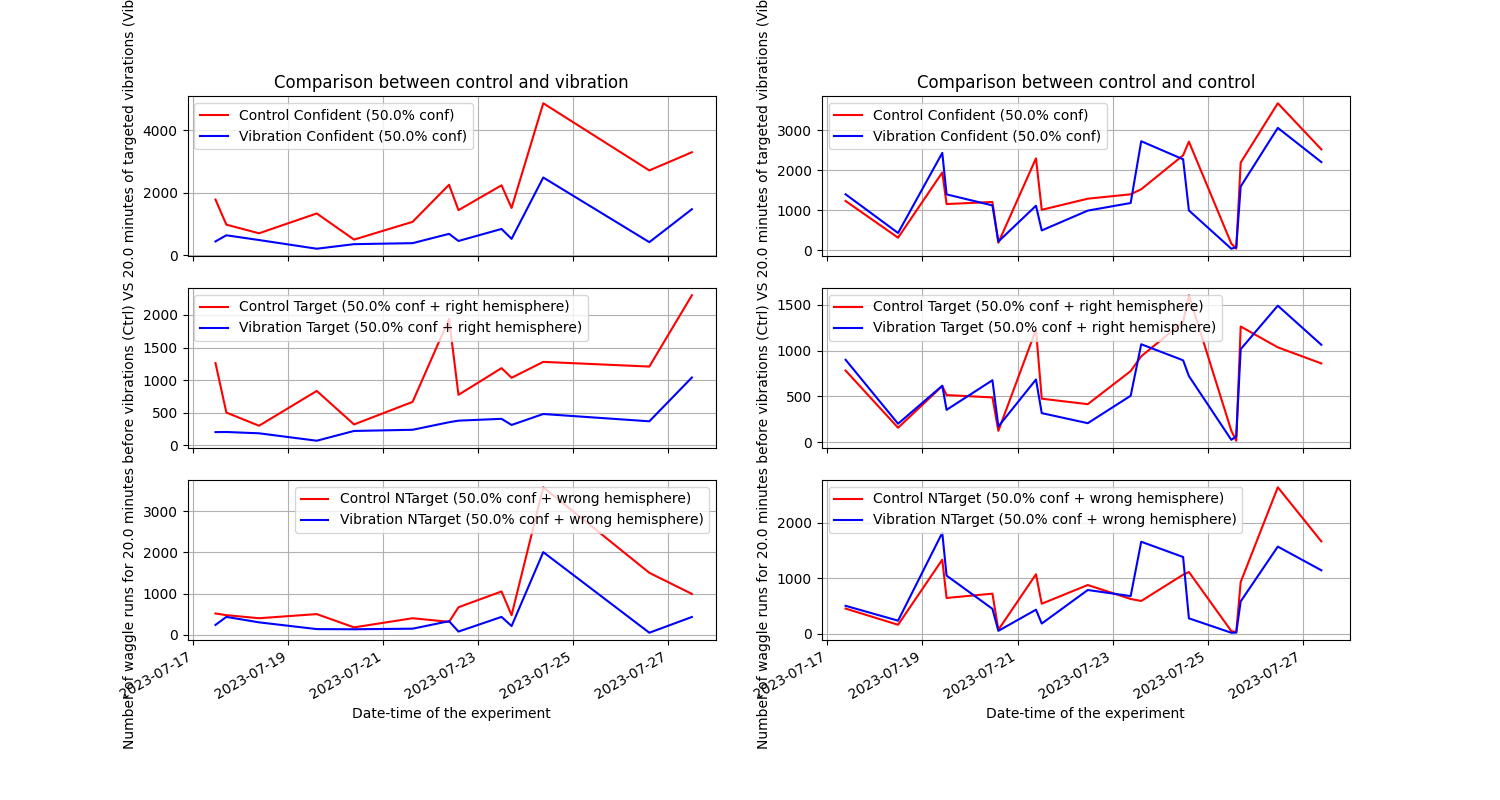

In [7]:
exp_results     = results[results.type == 'exp']
blank_results   = results[results.type == 'blank']

N_plots_h = 2
N_plots_v = 3
fig, ax = matplotlib.pyplot.subplots(N_plots_v, N_plots_h, figsize=(15,8), sharex=True)
ax[0,0].plot(exp_results.dtts_start, exp_results.Ccount_ctrl, c='r', label='Control Confident ({}% conf)'.format(WR_CONFIDENCE*100))
ax[0,0].plot(exp_results.dtts_start, exp_results.Ccount_vibs, c='b', label='Vibration Confident ({}% conf)'.format(WR_CONFIDENCE*100))

ax[1,0].plot(exp_results.dtts_start, exp_results.Tcount_ctrl, c='r', label='Control Target ({}% conf + right hemisphere)'.format(WR_CONFIDENCE*100))
ax[1,0].plot(exp_results.dtts_start, exp_results.Tcount_vibs, c='b', label='Vibration Target ({}% conf + right hemisphere)'.format(WR_CONFIDENCE*100))

ax[2,0].plot(exp_results.dtts_start, exp_results.NTcount_ctrl, c='r', label='Control NTarget ({}% conf + wrong hemisphere)'.format(WR_CONFIDENCE*100))
ax[2,0].plot(exp_results.dtts_start, exp_results.NTcount_vibs, c='b', label='Vibration NTarget ({}% conf + wrong hemisphere)'.format(WR_CONFIDENCE*100))



ax[0,1].plot(blank_results.dtts_start, blank_results.Ccount_ctrl, c='r', label='Control Confident ({}% conf)'.format(WR_CONFIDENCE*100))
ax[0,1].plot(blank_results.dtts_start, blank_results.Ccount_vibs, c='b', label='Vibration Confident ({}% conf)'.format(WR_CONFIDENCE*100))

ax[1,1].plot(blank_results.dtts_start, blank_results.Tcount_ctrl, c='r', label='Control Target ({}% conf + right hemisphere)'.format(WR_CONFIDENCE*100))
ax[1,1].plot(blank_results.dtts_start, blank_results.Tcount_vibs, c='b', label='Vibration Target ({}% conf + right hemisphere)'.format(WR_CONFIDENCE*100))

ax[2,1].plot(blank_results.dtts_start, blank_results.NTcount_ctrl, c='r', label='Control NTarget ({}% conf + wrong hemisphere)'.format(WR_CONFIDENCE*100))
ax[2,1].plot(blank_results.dtts_start, blank_results.NTcount_vibs, c='b', label='Vibration NTarget ({}% conf + wrong hemisphere)'.format(WR_CONFIDENCE*100))


for i in range(N_plots_v):
    for j in range(N_plots_h):
        ax[i,j].grid()
        ax[i,j].legend()

_ = ax[0,0].set_title('Comparison between control and vibration')
_ = ax[1,0].set_ylabel('Number of waggle runs for {} minutes before vibrations (Ctrl) VS {} minutes of targeted vibrations (Vibs)'.format(DURATION_EXPERIMENT.total_seconds()/60, DURATION_EXPERIMENT.total_seconds()/60))
_ = ax[2,0].set_xlabel('Date-time of the experiment')

_ = ax[0,1].set_title('Comparison between control and control')
_ = ax[1,1].set_ylabel('Number of waggle runs for {} minutes before vibrations (Ctrl) VS {} minutes of targeted vibrations (Vibs)'.format(DURATION_EXPERIMENT.total_seconds()/60, DURATION_EXPERIMENT.total_seconds()/60))
_ = ax[2,1].set_xlabel('Date-time of the experiment')

matplotlib.pyplot.gcf().autofmt_xdate()

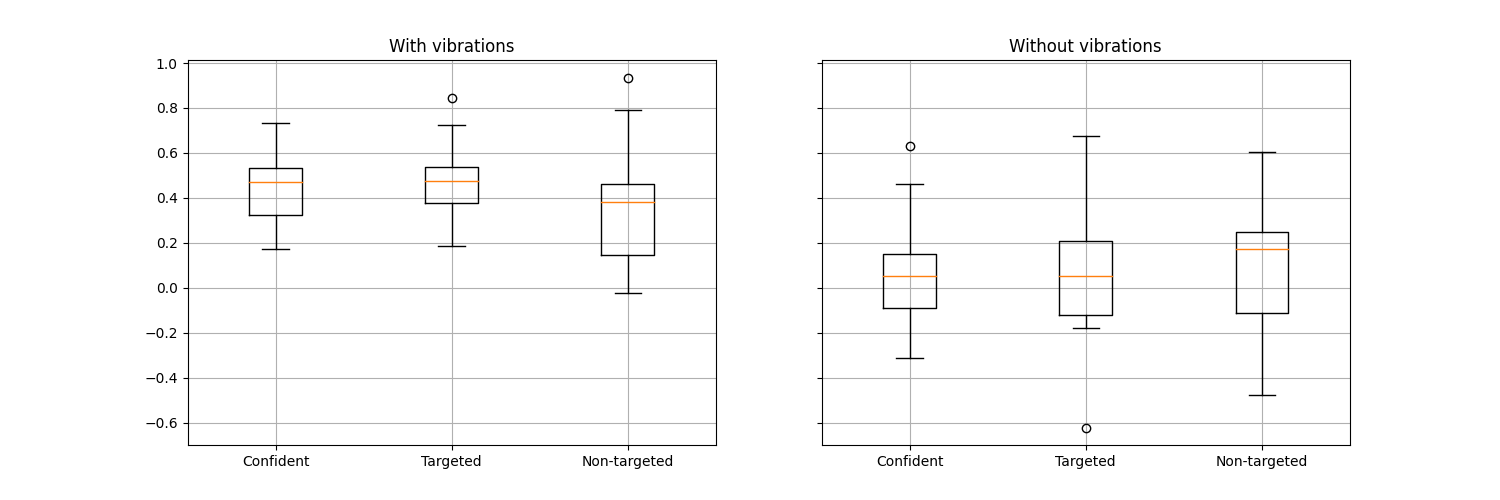

In [8]:
# date_limit = pytz.utc.localize(datetime.datetime(2023, 7, 23, 0, 0, 0))
# exp_results = exp_results[exp_results.dtts_start > date_limit]
# blank_results = blank_results[blank_results.dtts_start > date_limit]

C_drop_exp  = (exp_results.Ccount_ctrl-exp_results.Ccount_vibs)/(exp_results.Ccount_ctrl+exp_results.Ccount_vibs)
NT_drop_exp = (exp_results.NTcount_ctrl-exp_results.NTcount_vibs)/(exp_results.NTcount_ctrl+exp_results.NTcount_vibs)
T_drop_exp  = (exp_results.Tcount_ctrl-exp_results.Tcount_vibs)/(exp_results.Tcount_ctrl+exp_results.Tcount_vibs)
# C_drop_exp  = (exp_results.Ccount_ctrl-exp_results.Ccount_vibs)/(exp_results.Ccount_ctrl)
# NT_drop_exp = (exp_results.NTcount_ctrl-exp_results.NTcount_vibs)/(exp_results.NTcount_ctrl)
# T_drop_exp  = (exp_results.Tcount_ctrl-exp_results.Tcount_vibs)/(exp_results.Tcount_ctrl)

C_drop_exp_nanfree  = C_drop_exp.values[~numpy.isnan(C_drop_exp.values)]
NT_drop_exp_nanfree = NT_drop_exp.values[~numpy.isnan(NT_drop_exp.values)]
T_drop_exp_nanfree  = T_drop_exp.values[~numpy.isnan(T_drop_exp.values)]

C_drop_blank  = (blank_results.Ccount_ctrl-blank_results.Ccount_vibs)/(blank_results.Ccount_ctrl+blank_results.Ccount_vibs)
NT_drop_blank = (blank_results.NTcount_ctrl-blank_results.NTcount_vibs)/(blank_results.NTcount_ctrl+blank_results.NTcount_vibs)
T_drop_blank  = (blank_results.Tcount_ctrl-blank_results.Tcount_vibs)/(blank_results.Tcount_ctrl+blank_results.Tcount_vibs)
# C_drop_blank  = (blank_results.Ccount_ctrl-blank_results.Ccount_vibs)/(blank_results.Ccount_ctrl)
# NT_drop_blank = (blank_results.NTcount_ctrl-blank_results.NTcount_vibs)/(blank_results.NTcount_ctrl)
# T_drop_blank  = (blank_results.Tcount_ctrl-blank_results.Tcount_vibs)/(blank_results.Tcount_ctrl)

C_drop_blank_nanfree  = C_drop_blank.values[~numpy.isnan(C_drop_blank.values)]
NT_drop_blank_nanfree = NT_drop_blank.values[~numpy.isnan(NT_drop_blank.values)]
T_drop_blank_nanfree  = T_drop_blank.values[~numpy.isnan(T_drop_blank.values)]

fig, ax = matplotlib.pyplot.subplots(1, 2, figsize=(15,5), sharey=True)

ax[0].boxplot([C_drop_exp_nanfree, T_drop_exp_nanfree, NT_drop_exp_nanfree], labels=['Confident', 'Targeted','Non-targeted'])
ax[0].set_title('With vibrations')
ax[0].grid()

ax[1].boxplot([C_drop_blank_nanfree, T_drop_blank_nanfree, NT_drop_blank_nanfree], labels=['Confident', 'Targeted','Non-targeted'])
ax[1].set_title('Without vibrations')
ax[1].grid()

In [9]:
import scipy.stats

print("Result of test for all waggle runs : {}".format(scipy.stats.ranksums(C_drop_exp_nanfree, C_drop_blank_nanfree)))
print("Result of test for targeted waggle runs : {}".format(scipy.stats.ranksums(T_drop_exp_nanfree, T_drop_blank_nanfree)))
print("Result of test for NOT targeted waggle runs : {}".format(scipy.stats.ranksums(NT_drop_exp_nanfree, NT_drop_blank_nanfree)))

print("Result of test for targeted waggle runs VS NOT targeted ones : {}".format(scipy.stats.ranksums(T_drop_exp_nanfree, NT_drop_exp_nanfree)))

Result of test for all waggle runs : RanksumsResult(statistic=3.682947537517004, pvalue=0.0002305526207958935)
Result of test for targeted waggle runs : RanksumsResult(statistic=3.8030436528708194, pvalue=0.00014292915813465847)
Result of test for NOT targeted waggle runs : RanksumsResult(statistic=2.041633961014861, pvalue=0.04118785393317339)
Result of test for targeted waggle runs VS NOT targeted ones : RanksumsResult(statistic=1.358974358974359, pvalue=0.17415471397740334)


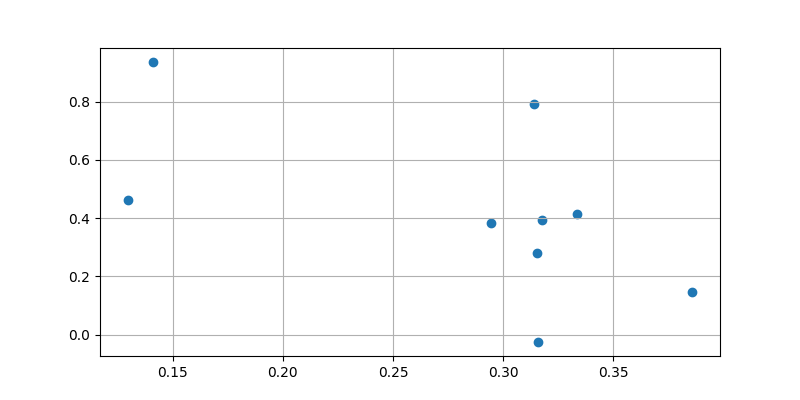

In [10]:
vibrations_periods_infos = pandas.read_pickle(root_path+'processed_actuation_phases.pickle')

limit_date = pytz.utc.localize(datetime.datetime(2023,7,20,0,0,0))
vibs_periods_to_consider=vibrations_periods_infos[vibrations_periods_infos.ts_start > limit_date]

exp_periods_to_consider = exp_results[exp_results.dtts_start > limit_date]
NT_drop_exp_to_consider = (exp_periods_to_consider.NTcount_ctrl-exp_periods_to_consider.NTcount_vibs)/(exp_periods_to_consider.NTcount_ctrl+exp_periods_to_consider.NTcount_vibs)
T_drop_exp_to_consider = (exp_periods_to_consider.Tcount_ctrl-exp_periods_to_consider.Tcount_vibs)/(exp_periods_to_consider.Tcount_ctrl+exp_periods_to_consider.Tcount_vibs)


fig = matplotlib.pyplot.figure(figsize=(8,4))
# matplotlib.pyplot.plot(exp_results.dtts_start, NT_drop_exp, 'r')
# # matplotlib.pyplot.plot(exp_results.dtts_start, T_drop_exp, 'g')
# matplotlib.pyplot.plot(vibrations_periods_infos['ts_start'], vibrations_periods_infos['ratio'],':ob')
matplotlib.pyplot.scatter(vibs_periods_to_consider['ratio'][:NT_drop_exp_to_consider.shape[0]], NT_drop_exp_to_consider)
matplotlib.pyplot.grid()

In [11]:
vibs_periods_to_consider

,ts_start,ts_stop,sb0,sb1,sbtimes,on_off,ratio,actuation_durations
4,2023-07-20 09:10:00+02:00,2023-07-20 11:10:00+02:00,"[11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 1...","[11, 11, 0, 11, 0, 11, 0, 11, 0, 11, 0, 11, 0,...","[2023-07-20 09:10:00+02:00, 2023-07-20 07:13:1...","[0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, ...",0.385609,"{'on': 2776.3879550000056, 'off': 4423.6120449..."
5,2023-07-21 14:45:00+02:00,2023-07-21 16:45:00+02:00,"[11, 11, 11, 1, 1, 11, 11, 11, 0, 0, 11, 11, 0...","[11, 11, 11, 11, 11, 11, 0, 11, 11, 0, 0, 11, ...","[2023-07-21 14:45:00+02:00, 2023-07-21 12:46:5...","[0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, ...",0.129846,"{'on': 934.8912830000003, 'off': 6265.10871699..."
6,2023-07-22 09:10:00+02:00,2023-07-22 11:10:00+02:00,"[11, 1, 0, 11, 11, 1, 11, 0, 0, 0, 1, 1, 0, 11...","[11, 11, 11, 11, 11, 11, 11, 11, 1, 1, 1, 11, ...","[2023-07-22 09:10:00+02:00, 2023-07-22 07:10:0...","[0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, ...",0.315752,"{'on': 2273.4178889999976, 'off': 4926.5821109..."
7,2023-07-22 13:55:00+02:00,2023-07-22 15:55:00+02:00,"[11, 0, 11, 11, 0, 0, 11, 0, 0, 11, 0, 0, 11, ...","[11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 1...","[2023-07-22 13:55:00+02:00, 2023-07-22 11:55:0...","[0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, ...",0.314162,"{'on': 2261.969415999999, 'off': 4938.03058399..."
8,2023-07-23 11:40:00+02:00,2023-07-23 13:40:00+02:00,"[11, 0, 11, 0, 0, 11, 1, 0, 11, 11, 0, 0, 1, 1...","[11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 1...","[2023-07-23 11:40:00+02:00, 2023-07-23 09:40:0...","[0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, ...",0.333517,"{'on': 2401.3246229999977, 'off': 4798.6753769..."
9,2023-07-23 16:45:00+02:00,2023-07-23 18:45:00+02:00,"[11, 11, 11, 11, 1, 1, 11, 11, 11, 0, 11, 0, 1...","[11, 0, 0, 11, 11, 0, 0, 0, 11, 11, 11, 11, 11...","[2023-07-23 16:45:00+02:00, 2023-07-23 14:45:0...","[0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, ...",0.294653,"{'on': 2121.498569, 'off': 5078.501431000001}"
10,2023-07-24 08:45:00+02:00,2023-07-24 10:45:00+02:00,"[11, 11, 11, 11, 0, 11, 0, 11, 0, 11, 0, 11, 0...","[11, 0, 0, 11, 11, 11, 11, 11, 11, 11, 11, 11,...","[2023-07-24 08:45:00+02:00, 2023-07-24 06:45:0...","[0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, ...",0.315437,"{'on': 2271.147511999996, 'off': 4928.85248799..."
11,2023-07-26 14:20:00+02:00,2023-07-26 16:20:00+02:00,"[11, 0, 11, 0, 11, 11, 0, 11, 0, 11, 0, 11, 0,...","[11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 1...","[2023-07-26 14:20:00+02:00, 2023-07-26 12:20:0...","[0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, ...",0.141219,"{'on': 1016.7746539999997, 'off': 6183.2253460..."
12,2023-07-27 11:50:00+02:00,2023-07-27 13:50:00+02:00,"[11, 0, 11, 11, 11, 0, 0, 11, 1, 11, 0, 11, 0,...","[11, 11, 11, 1, 11, 11, 11, 11, 11, 11, 11, 11...","[2023-07-27 11:50:00+02:00, 2023-07-27 09:50:0...","[0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, ...",0.317545,"{'on': 2286.3208720000016, 'off': 4913.6791279..."
13,2023-07-29 12:30:00+02:00,2023-07-29 13:00:00+02:00,"[11, 0, 11, 0, 11, 11, 11, 11, 0, 11, 0, 11, 0...","[11, 11, 11, 11, 11, 1, 11, 11, 11, 11, 11, 11...","[2023-07-29 12:30:00+02:00, 2023-07-29 10:30:3...","[0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, ...",0.340524,"{'on': 612.942495, 'off': 1187.0575049999998}"


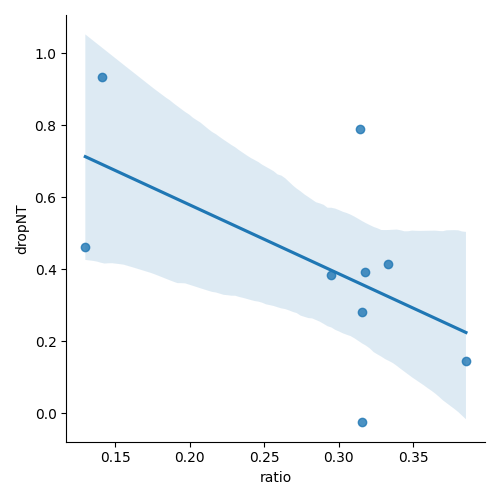

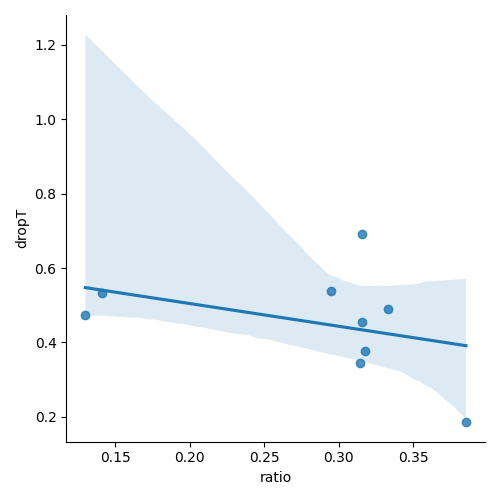

In [12]:
import seaborn
plot_df = pandas.DataFrame.from_dict({'ratio':vibs_periods_to_consider['ratio'][:NT_drop_exp_to_consider.shape[0]], 'dropNT':NT_drop_exp_to_consider.values, 'dropT':T_drop_exp_to_consider.values})
plot_df = plot_df[plot_df.ratio != 0]
seaborn.lmplot(data=plot_df, x='ratio', y='dropNT')
seaborn.lmplot(data=plot_df, x='ratio', y='dropT')

In [13]:
plot_df

,ratio,dropNT,dropT
4,0.385609,0.146497,0.185185
5,0.129846,0.461818,0.473451
6,0.315752,-0.024845,0.691369
7,0.314162,0.790885,0.343750
8,0.333517,0.415882,0.489308
9,0.294653,0.383721,0.537092
10,0.315437,0.281776,0.454545
11,0.141219,0.935650,0.532995
12,0.317545,0.393258,0.377618


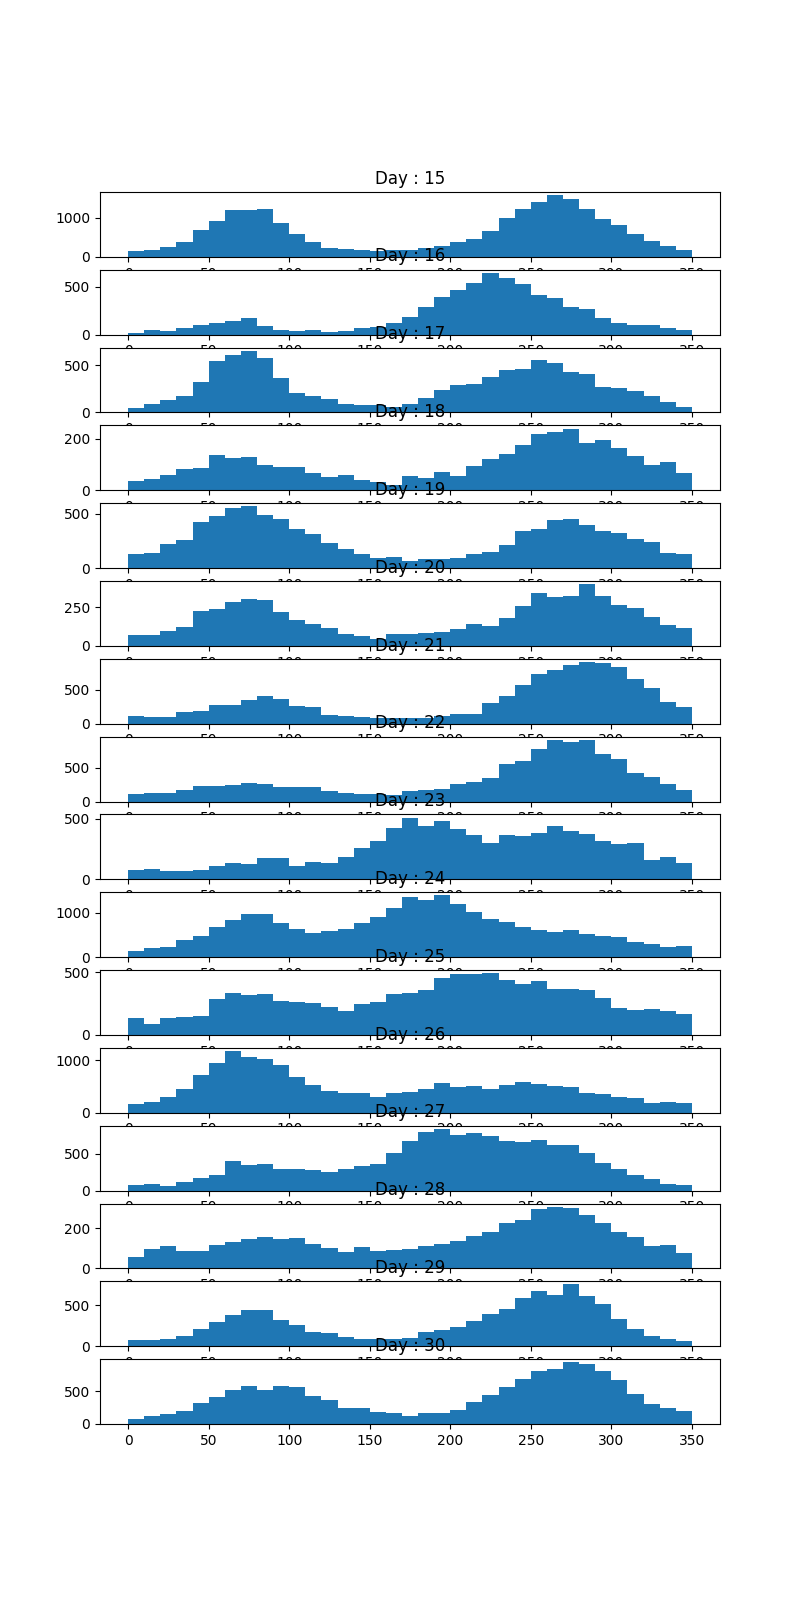

In [14]:
# subplots for day-by-day trend
boundary_day = 16

all_confident = all_waggles_df[all_waggles_df.label_confidence>0.99]
all_confident_1feeder = all_confident[all_confident.timestamp_begin < pytz.utc.localize(datetime.datetime(2023, 7, boundary_day, 1, 0, 0))]
all_confident_2feeder = all_confident[all_confident.timestamp_begin > pytz.utc.localize(datetime.datetime(2023, 7, boundary_day, 1, 0, 0))]

# matplotlib.pyplot.figure()
# matplotlib.pyplot.hist((all_confident_1feeder.world_angle_deg-50)%360, bins=numpy.arange(0, 360, 10))#, density=True)
# matplotlib.pyplot.hist((all_confident_2feeder.world_angle_deg-50)%360, bins=numpy.arange(0, 360, 10), density=True, alpha=0.5)

fig, ax = matplotlib.pyplot.subplots(16, 1, figsize=(8, 16))
for d in range(15, 31):
    waggles_of_day = all_confident[all_confident.timestamp_begin > pytz.utc.localize(datetime.datetime(2023, 7, d, 1, 0, 0))]
    waggles_of_day = waggles_of_day[waggles_of_day.timestamp_begin < pytz.utc.localize(datetime.datetime(2023, 7, d + 1, 1, 0, 0))]
    ax[d-15].hist((waggles_of_day.world_angle_deg-50)%360, bins=numpy.arange(0, 360, 10))
    ax[d-15].set_title('Day : {}'.format(d))

In [15]:
# 21st of July investigation
date_lower_limit = pytz.utc.localize(datetime.datetime(2023, 7, 21, 0, 0, 0))
date_upper_limit = pytz.utc.localize(datetime.datetime(2023, 7, 22, 0, 0, 0))

waggles_day = all_waggles_df[all_waggles_df.timestamp_begin > date_lower_limit]
waggles_day = waggles_day[waggles_day.timestamp_begin < date_upper_limit]
waggles_day = waggles_day[waggles_day.label_confidence > 0.99]

exp_day = exp_configs[exp_configs.dtts_start > date_lower_limit]
exp_day = exp_day[exp_day.dtts_start < date_upper_limit]

exp_day

,from,to,rule,dtts_start,dtts_stop,angle_deg
12,2023-07-21T09:20:00+02:00,2023-07-21T11:20:00+02:00,no_vibrate,2023-07-21 09:20:00+02:00,2023-07-21 11:20:00+02:00,314.0
13,2023-07-21T12:15:00+02:00,2023-07-21T14:15:00+02:00,no_vibrate,2023-07-21 12:15:00+02:00,2023-07-21 14:15:00+02:00,314.0
14,2023-07-21T14:45:00+02:00,2023-07-21T16:45:00+02:00,vibrate,2023-07-21 14:45:00+02:00,2023-07-21 16:45:00+02:00,314.0


In [16]:
waggles_ctrl = waggles_day[waggles_day.timestamp_begin > exp_day.iloc[0].dtts_start - DURATION_EXPERIMENT]
waggles_ctrl = waggles_ctrl[waggles_ctrl.timestamp_begin < exp_day.iloc[0].dtts_start]
waggles_ctrl

,waggle_id,dance_id,waggle_angle,dance_angle,waggle_duration,cam_id,timestamp_begin,timestamp_end,wdd_x,wdd_y,...,end_x,end_y,date,timestamp_duration,azimuth,world_angle,dance_world_angle,world_angle_deg,dance_world_angle_deg,was_clustered_to_dance
108225,11945201808020685940,259,-2.279559,3.820822,0.974908,2,2023-07-21 07:01:51.993564+00:00,2023-07-21 07:01:53.143634+00:00,1350.0,1216.0,...,1326.0,1236.0,2023-07-21,1.150070,-0.118619,-3.968974,2.131407,-227.405434,122.120607,True
108226,10398476057460858693,258,-1.262439,1.077259,0.698607,2,2023-07-21 07:01:18.425102+00:00,2023-07-21 07:01:19.113092+00:00,1502.0,1040.0,...,1478.0,1064.0,2023-07-21,0.687990,-0.116695,-2.949930,-0.610232,-169.018561,-34.963740,True
108235,17033179971524776429,263,-2.598074,3.798199,0.560048,2,2023-07-21 07:01:56.777080+00:00,2023-07-21 07:01:57.777263+00:00,1326.0,1192.0,...,1310.0,1208.0,2023-07-21,1.000183,-0.118893,-4.287763,2.108510,-245.670734,120.808719,True
108236,10915506918717444298,258,-2.329008,1.023991,0.588199,2,2023-07-21 07:01:14.098757+00:00,2023-07-21 07:01:15.091636+00:00,1518.0,1248.0,...,1510.0,1256.0,2023-07-21,0.992879,-0.116447,-4.016252,-0.663252,-230.114275,-38.001562,True
108238,14271960339607029092,259,0.768604,3.820822,0.884427,2,2023-07-21 07:01:53.576950+00:00,2023-07-21 07:01:53.776897+00:00,1350.0,1200.0,...,1350.0,1200.0,2023-07-21,0.199947,-0.118709,-0.920902,2.131316,-52.763771,122.115404,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
484388,14502451908439308200,480,-1.734601,4.253881,0.986970,2,2023-07-21 07:18:03.595782+00:00,2023-07-21 07:18:04.829278+00:00,1294.0,1152.0,...,1286.0,1184.0,2023-07-21,1.233496,-0.175533,-3.480930,2.507552,-199.442586,143.672152,True
484397,10361313036351164809,491,-2.199955,3.828596,0.733652,2,2023-07-21 07:18:42.231296+00:00,2023-07-21 07:18:42.751753+00:00,1718.0,956.0,...,1710.0,976.0,2023-07-21,0.520457,-0.177849,-3.948600,2.079950,-226.238131,119.172378,True
484398,16341169031748529497,487,-1.269066,4.919762,0.556346,2,2023-07-21 07:18:23.146791+00:00,2023-07-21 07:18:23.847096+00:00,1246.0,1216.0,...,1246.0,1224.0,2023-07-21,0.700305,-0.176704,-3.016567,3.172261,-172.836571,181.757181,True
484399,17681685320165753708,496,1.146897,3.680772,0.921692,2,2023-07-21 07:18:56.815156+00:00,2023-07-21 07:18:58.146744+00:00,1470.0,928.0,...,1470.0,888.0,2023-07-21,1.331588,-0.178725,-0.602624,1.931251,-34.527803,110.652523,True


In [17]:
waggles_vibs = waggles_day[waggles_day.timestamp_begin > exp_day.iloc[0].dtts_start]
waggles_vibs = waggles_vibs[waggles_vibs.timestamp_begin < exp_day.iloc[0].dtts_start + DURATION_EXPERIMENT]
waggles_vibs

,waggle_id,dance_id,waggle_angle,dance_angle,waggle_duration,cam_id,timestamp_begin,timestamp_end,wdd_x,wdd_y,...,end_x,end_y,date,timestamp_duration,azimuth,world_angle,dance_world_angle,world_angle_deg,dance_world_angle_deg,was_clustered_to_dance
108276,9619384724066102446,711,-1.370345,4.306028,1.017148,2,2023-07-21 07:39:49.145251+00:00,2023-07-21 07:39:51.512059+00:00,1250.000000,1036.000000,...,1292.165138,1044.755963,2023-07-21,2.366808,-0.256430,-3.197572,2.478801,-183.207387,142.024858,True
108277,13939324782753919089,708,-1.850122,4.292144,1.140485,2,2023-07-21 07:39:26.694146+00:00,2023-07-21 07:39:28.044117+00:00,1234.703030,970.698990,...,1267.144812,1043.644714,2023-07-21,1.349971,-0.254990,-3.675908,2.466358,-210.614033,141.311915,True
108278,16933515400201288383,708,-1.978667,4.296296,0.972438,2,2023-07-21 07:39:31.444247+00:00,2023-07-21 07:39:33.011082+00:00,1198.000000,982.561404,...,1193.169329,1010.950283,2023-07-21,1.566835,-0.255294,-3.804758,2.470206,-217.996550,141.532361,True
108279,14491904867483111855,708,-2.131960,4.292144,1.536337,2,2023-07-21 07:39:29.877531+00:00,2023-07-21 07:39:31.427676+00:00,1242.610478,919.817768,...,1303.220957,903.635535,2023-07-21,1.550145,-0.255194,-3.957950,2.466154,-226.773835,141.300217,True
108287,17513939253078882831,708,-1.888950,4.320889,0.928978,2,2023-07-21 07:39:33.311084+00:00,2023-07-21 07:39:37.827915+00:00,1138.000000,964.000000,...,1062.000000,936.000000,2023-07-21,4.516831,-0.255414,-3.715161,2.494678,-212.863024,142.934534,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
484458,12306142423665519077,694,1.890379,1.520164,0.914116,2,2023-07-21 07:38:04.240463+00:00,2023-07-21 07:38:04.739699+00:00,1582.000000,984.000000,...,1578.000000,972.000000,2023-07-21,0.499236,-0.249715,0.069868,-0.300347,4.003114,-17.208612,True
484460,9647917560838667989,699,0.717862,0.494908,0.547000,2,2023-07-21 07:38:35.074700+00:00,2023-07-21 07:38:35.432939+00:00,1407.992337,1002.666667,...,1361.984674,989.333333,2023-07-21,0.358239,-0.251684,-1.104618,-1.327573,-63.289978,-76.064309,True
484465,16332158280871609586,697,-2.434717,3.874455,0.559322,2,2023-07-21 07:38:14.012905+00:00,2023-07-21 07:38:14.956866+00:00,1054.000000,1280.000000,...,1062.000000,1304.000000,2023-07-21,0.943961,-0.250339,-4.255852,2.053320,-243.842352,117.646582,True
484467,14637562878447031490,700,1.481397,0.911157,0.733498,2,2023-07-21 07:38:38.606336+00:00,2023-07-21 07:38:41.838121+00:00,1435.856813,1039.796767,...,1478.643515,1011.475452,2023-07-21,3.231785,-0.251910,-0.341309,-0.911549,-19.555575,-52.227930,True


In [18]:
print(abs((waggles_vibs.dance_world_angle_deg.values%360)-314%360)%360)

[171.9751424  172.68808509 172.4676392  172.69978253 171.06546588
 166.24552652  61.97963069  42.54620038 291.48267821 188.54161784
  18.7340464   43.56471999  27.99319452 308.84622342 308.83772898
  37.87346887 299.95416365  43.81631647  45.38416239  35.69436915
  26.61376373   1.27596425  27.72100724  24.548732   309.12623734
  12.52583918 197.3160109   28.28465506 311.0824103  308.61710566
  37.54185198  27.71334167 303.45461296 303.46848238 298.25959931
  35.86460259 298.26000006 309.13457711 312.07823457  37.88132538
 197.30288453  15.8550953   27.98909422  44.50541873  26.61405002
 302.42587612 285.83259697  35.85328214 302.18097239  37.5462465
 107.26675152  34.60302404 159.95855034  35.75010795 285.10159596
 298.96862297   3.72538273 303.88807369 284.30413228  45.7067943
 209.16874187  27.13177911 147.01909731 217.74952989  20.59865766
 209.17613028 107.27224765 284.30434077 130.21429267 301.43323396
 305.47893662 289.14277326  37.70432555 312.66510206  36.49717542
  44.0953732

In [19]:
print(waggles_vibs.was_clustered_to_dance.values)

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  T

In [20]:
(-10)%360

350

In [21]:
vibrations_periods_infos.sort_values(by='ratio')

,ts_start,ts_stop,sb0,sb1,sbtimes,on_off,ratio,actuation_durations
18,2023-07-29 17:30:00+02:00,2023-07-29 18:00:00+02:00,"[11, 11]","[11, 11]","[2023-07-29 17:30:00+02:00, 2023-07-29 18:00:0...","[0, 0]",0.000000,"{'on': 0, 'off': 1800.0}"
0,2023-07-17 11:10:00+02:00,2023-07-17 13:10:00+02:00,"[11, 1, 0, 1, 0, 1, 11, 11, 1, 11, 1, 1, 11, 1...","[11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 1...","[2023-07-17 11:10:00+02:00, 2023-07-17 09:10:0...","[0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, ...",0.063577,"{'on': 457.7530269999998, 'off': 6742.246973}"
20,2023-07-30 11:30:00+02:00,2023-07-30 12:00:00+02:00,"[11, 1, 11, 0, 11, 0, 11, 11, 11, 11, 0, 11, 0...","[11, 11, 11, 11, 11, 11, 11, 0, 11, 11, 11, 11...","[2023-07-30 11:30:00+02:00, 2023-07-30 09:30:3...","[0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, ...",0.111871,"{'on': 201.36783699999998, 'off': 1598.6321630..."
1,2023-07-17 16:40:00+02:00,2023-07-17 18:40:00+02:00,"[11, 11, 11, 1, 1, 11, 0, 0, 0, 0, 0, 11, 0, 1...","[11, 0, 11, 11, 11, 11, 11, 11, 0, 0, 11, 11, ...","[2023-07-17 16:40:00+02:00, 2023-07-17 14:40:0...","[0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, ...",0.129820,"{'on': 934.7069709999997, 'off': 6265.29302899..."
5,2023-07-21 14:45:00+02:00,2023-07-21 16:45:00+02:00,"[11, 11, 11, 1, 1, 11, 11, 11, 0, 0, 11, 11, 0...","[11, 11, 11, 11, 11, 11, 0, 11, 11, 0, 0, 11, ...","[2023-07-21 14:45:00+02:00, 2023-07-21 12:46:5...","[0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, ...",0.129846,"{'on': 934.8912830000003, 'off': 6265.10871699..."
2,2023-07-18 09:10:00+02:00,2023-07-18 11:10:00+02:00,"[11, 0, 11, 0, 11, 0, 0, 0, 11, 0, 11, 0, 11, ...","[11, 11, 11, 11, 11, 11, 0, 11, 11, 11, 11, 11...","[2023-07-18 09:10:00+02:00, 2023-07-18 07:11:1...","[0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, ...",0.139186,"{'on': 1002.1378149999999, 'off': 6197.8621849..."
11,2023-07-26 14:20:00+02:00,2023-07-26 16:20:00+02:00,"[11, 0, 11, 0, 11, 11, 0, 11, 0, 11, 0, 11, 0,...","[11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 1...","[2023-07-26 14:20:00+02:00, 2023-07-26 12:20:0...","[0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, ...",0.141219,"{'on': 1016.7746539999997, 'off': 6183.2253460..."
14,2023-07-29 13:30:00+02:00,2023-07-29 14:00:00+02:00,"[11, 11, 11, 11, 11, 11, 11, 0, 11, 0, 11, 0, ...","[11, 0, 11, 1, 11, 0, 11, 11, 11, 11, 11, 11, ...","[2023-07-29 13:30:00+02:00, 2023-07-29 11:30:5...","[0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, ...",0.160758,"{'on': 289.36407, 'off': 1510.6359300000004}"
21,2023-07-30 12:30:00+02:00,2023-07-30 13:00:00+02:00,"[11, 0, 11, 0, 11, 1, 11, 0, 11, 1, 11, 0, 11,...","[11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 1...","[2023-07-30 12:30:00+02:00, 2023-07-30 10:30:0...","[0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, ...",0.188116,"{'on': 338.609259, 'off': 1461.3907410000002}"
39,2023-08-02 10:10:00+02:00,2023-08-02 10:40:00+02:00,"[11, 0, 11, 11, 11, 11, 11, 0, 11, 1, 11, 1, 1...","[11, 11, 11, 0, 11, 0, 11, 11, 11, 11, 11, 11,...","[2023-08-02 10:10:00+02:00, 2023-08-02 08:10:0...","[0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, ...",0.211098,"{'on': 379.9765000000001, 'off': 1420.02350000..."
